# Settings

In [8]:
from pathlib import Path

import pandas as pd
pd.plotting.register_matplotlib_converters()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

In [21]:
syntanic_data_path = Path(r'.\data\train.csv')
syntanic_data = pd.read_csv(syntanic_data_path, index_col='PassengerId')
syntanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# Context

Здесь использован синтетический набор данных, но основан на реальных данных с Титаника.

В данных следующие колонки: ``` ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] ```, а ```'PassengerId'``` использован как индекс строки.

# Data quality assessment

Количество строк (пассажиров) в данных 100000


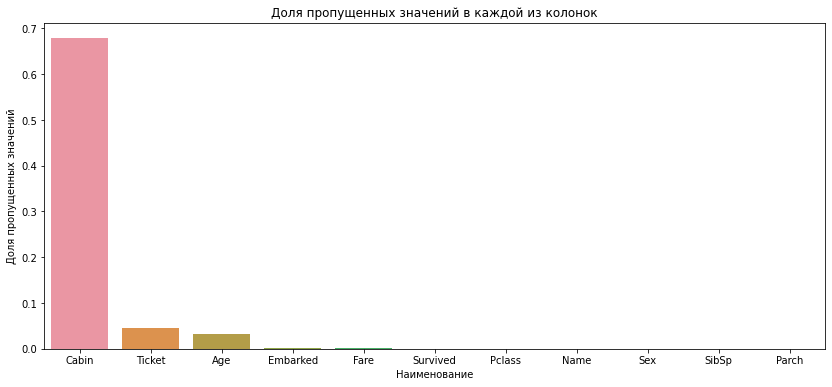

Среди колонок наибольшее количество пропущенных значений имеет номер кабины ('Cabin' = 67.87%), далее номер билета ('Ticket' = 4.62%) и возраст ('Age' = 3.29%), а наименьшее - порт назначения ('Embarked' = 0.25%) и тариф ('Fare' = 0.13%). В остальных колонках нет пропущенных значений.
При этом во всем датасете обнаружено 0 полностью пустых строк


In [94]:
total_rows = syntanic_data.shape[0]
print(f'Количество строк (пассажиров) в данных {syntanic_data.shape[0]}')

plt.figure(figsize=(14, 6))
plt.title('Доля пропущенных значений в каждой из колонок')
plt.xlabel('Наименование')
plt.ylabel('Доля пропущенных значений')

na_fraction = (syntanic_data.isna().sum() / total_rows).sort_values(ascending=False)
sb.barplot(x=na_fraction.index, y=na_fraction)
plt.show()

print('Среди колонок наибольшее количество пропущенных значений имеет '
      'номер кабины (\'Cabin\' = {:.2%}), далее номер билета '
      '(\'Ticket\' = {:.2%}) и возраст (\'Age\' = {:.2%}), '
      'а наименьшее - порт назначения (\'Embarked\' = {:.2%}) '
      'и тариф (\'Fare\' = {:.2%}). В остальных колонках '
      'нет пропущенных значений.'\
      .format(na_fraction['Cabin'], na_fraction['Ticket'], na_fraction['Age'],
              na_fraction['Embarked'], na_fraction['Fare']))
print('При этом во всем датасете обнаружено {:d} полностью пустых строк'\
      .format(total_rows - syntanic_data.dropna(how='all').shape[0]))

Датасет имеет 0 строк-дубликатов


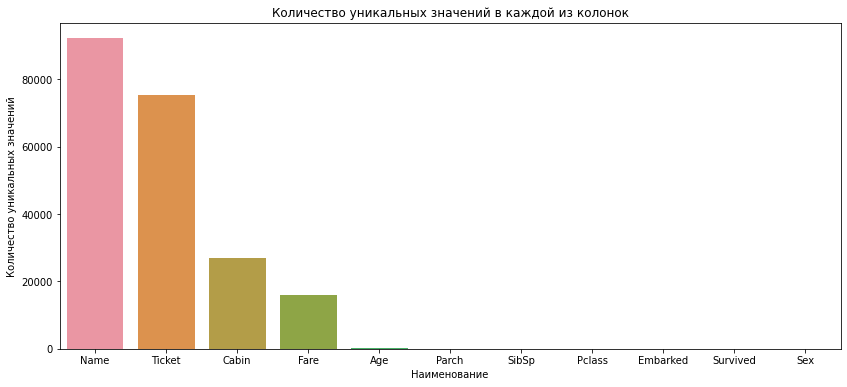

При расчете отсутвующие значения отбрасывались. Среди данных уникальных имен 92144, номеров билетов 75331 (самый часто встречающийся билет - 'A/5 ' (601 раз)), номеров кают 26992 (что логично, так как каюты бывают многоместные и также в этих данных больше всего отсутствующих значений)
Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается предположение, что в этом поле много невалидных данных. В дальнейшем обработка может проводиться только по уникальным номерам билетов (о чем будет написано)


In [97]:
print('Датасет имеет {:d} строк-дубликатов'\
      .format(syntanic_data[syntanic_data.duplicated()].shape[0]))

plt.figure(figsize=(14, 6))
plt.title('Количество уникальных значений в каждой из колонок')
plt.xlabel('Наименование')
plt.ylabel('Количество уникальных значений')

unique_values_count = syntanic_data.nunique(dropna=True).sort_values(ascending=False)
sb.barplot(x=unique_values_count.index, y=unique_values_count)
plt.show()

duplicated_tickets = syntanic_data['Ticket'].dropna()[syntanic_data['Ticket']\
      .dropna().duplicated()].value_counts()

print('При расчете отсутвующие значения отбрасывались. '
      'Среди данных уникальных имен {:d}, номеров билетов {:d} '
      '(самый часто встречающийся билет - \'{}\' ({:d} раз)), '
      'номеров кают {:d} (что логично, так как каюты бывают '
      'многоместные и также в этих данных больше всего '
      'отсутствующих значений)'\
      .format(unique_values_count['Name'], unique_values_count['Ticket'],
              duplicated_tickets.idxmax(), duplicated_tickets.max(),
              unique_values_count['Cabin']))

print('Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается '
      'предположение, что в этом поле много невалидных данных. В дальнейшем обработка '
      'может проводиться только по уникальным номерам билетов (о чем будет написано)')

In [100]:
print('В ходе изучения данных выдвинуто предположение, '
      'что основной целью является выявление степени '
      'влияния различных параметров на вероятность выживания '
      'пассажира. Однако это не отбрасывает интерес к зависимостям  '
      'между другими параметрами')

В ходе изучения данных выдвинуто предположение, что основной целью является выявление степени влияния различных параметров на вероятность выживания пассажира. Однако это не отбрасывает интерес к зависимостям  между другими параметрами


# Data exploration

# Summary